In [29]:
import os
import random
import shutil
import time
import warnings

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim

import torch.utils.data
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

This is a test

In [30]:
SEED=1

In [31]:
random.seed(SEED)
torch.manual_seed(SEED)
cudnn.deterministic = True

In [32]:
torch.cuda.device_count()

1

### Set the architecture to resnet 18 below

In [33]:
START_EPOCH = 0

In [34]:
##########################
ARCH = 'resnet18'# set the architecture to RESNET 18
# please look up how to do that
########################
EPOCHS = 100
LR = 0.1
MOMENTUM = 0.9
WEIGHT_DECAY = 1e-4
PRINT_FREQ = 50
TRAIN_BATCH=128
VAL_BATCH=128
WORKERS=2
TRAINDIR="/data/imagenet2012/train"
VALDIR="/data/imagenet2012/val"

In [35]:
# TRAINDIR="/CINIC/train"
# VALDIR="/CINIC/valid"

### Check if cuda is available here

In [36]:
# check if cuda is available in this cell
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


### Assign your GPU below

In [37]:
# Assign your GPU in this cell
GPU = 0

In [38]:
# set your active device to your GPU in this cell
torch.cuda.set_device(GPU)

In [39]:
# enable algorithm optimization
cudnn.benchmark = True

### Fill in the heart of the train section below

In [40]:
def train(train_loader, model, criterion, optimizer, epoch):
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    progress = ProgressMeter(
        len(train_loader),
        [batch_time, data_time, losses, top1, top5],
        prefix="Epoch: [{}]".format(epoch))

    # switch model to train mode here
    model.train()

    end = time.time()
    for i, (images, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        #####################
        # send the images to cuda device
        # send the target to cuda device
        if GPU is not None:
            images = images.cuda(GPU, non_blocking=True)
        if torch.cuda.is_available():
            target = target.cuda(GPU, non_blocking=True)


        # compute output - forward pass
        output = model(images)

        # compute loss 
        loss = criterion(output, target)


        # measure accuracy and record loss
        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        losses.update(loss.item(), images.size(0))
        top1.update(acc1[0], images.size(0))
        top5.update(acc5[0], images.size(0))

        # compute gradient and do SGD step
        # zero out gradients in the optimier - think about gradient accumulation
        optimizer.zero_grad()
        
        # backward pass - calculate gradients
        loss.backward()
        
        # update the weights
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % PRINT_FREQ == 0:
            progress.display(i)

#### Fill in the validate section below

In [41]:
def validate(val_loader, model, criterion):
    batch_time = AverageMeter('Time', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    progress = ProgressMeter(
        len(val_loader),
        [batch_time, losses, top1, top5],
        prefix='Test: ')

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        end = time.time()
        for i, (images, target) in enumerate(val_loader):
            # send the images and target to cuda
            if GPU is not None:
                images = images.cuda(GPU, non_blocking=True)
            if torch.cuda.is_available():
                target = target.cuda(GPU, non_blocking=True)

            # compute output
            output = model(images)
            
            # compute loss
            loss  = criterion(output, target)


            # measure accuracy and record loss
            acc1, acc5 = accuracy(output, target, topk=(1, 5))
            losses.update(loss.item(), images.size(0))
            top1.update(acc1[0], images.size(0))
            top5.update(acc5[0], images.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % PRINT_FREQ == 0:
                progress.display(i)

        # TODO: this should also be done with the ProgressMeter
        print(' * Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f}'
              .format(top1=top1, top5=top5))

    return top1.avg

### Save the checkpoint

In [42]:
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    # save the model state!
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')

In [43]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)

In [44]:
class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'

In [45]:
# if we are adjusting the LR manually use this
def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = LR * (0.1 ** (epoch // 20))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [46]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [47]:
imagenet_mean_RGB = [0.47889522, 0.47227842, 0.43047404]
imagenet_std_RGB = [0.229, 0.224, 0.225]
cinic_mean_RGB = [0.47889522, 0.47227842, 0.43047404]
cinic_std_RGB = [0.24205776, 0.23828046, 0.25874835]
cifar_mean_RGB = [0.4914, 0.4822, 0.4465]
cifar_std_RGB = [0.2023, 0.1994, 0.2010]

In [48]:
normalize = transforms.Normalize(mean=cifar_mean_RGB, std=cifar_std_RGB)

In [49]:
# IMG_SIZE = 32
IMG_SIZE = 224

In [50]:
NUM_CLASSES = 1000

### Initialize the model using the architecture you selected above

In [51]:
# select the model
model = models.__dict__[ARCH]() 
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)

### Send the model to the cuda device

In [52]:
# send the model to the cuda device
model.cuda(GPU)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Instantiate the loss to cross entropy

In [53]:
# use the cross-entropy loss
criterion = nn.CrossEntropyLoss().cuda(GPU)

### Instantiate the optimizer to SGD

In [54]:
# use SGD .. use the momentum and weight decay vars
optimizer = torch.optim.SGD(model.parameters(), LR,
                               momentum=MOMENTUM,
                               weight_decay=WEIGHT_DECAY)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

#### Create the learning rate scheduler

In [55]:
# use CosineAnnealingLR
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

### Training Data

#### Training Data Transform

In [56]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
#     transforms.RandomCrop(224, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean_RGB, imagenet_std_RGB),
])

#### Create the train dataset object

In [57]:
train_dataset = torchvision.datasets.ImageFolder(
        TRAINDIR, transform=transform_train)


#### Create the train data loader

In [58]:
# fill this in
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=TRAIN_BATCH, shuffle=True,
    num_workers=WORKERS, pin_memory=True, sampler=None)

### Validation Data

#### Validation Data Transform

In [59]:
transform_val = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean_RGB, imagenet_std_RGB),
])

#### Create the validation dataset object

In [60]:
val_dataset = datasets.ImageFolder(
    VALDIR, transform=transform_val)

#### Create the validation data loader

In [61]:
# fill this in..
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=VAL_BATCH, shuffle=False,
    num_workers=WORKERS, pin_memory=True, sampler=None) 

In [62]:
best_acc1 = 0

In [ ]:
for epoch in range(START_EPOCH, EPOCHS):
    adjust_learning_rate(optimizer, epoch)

    # train for one epoch
    train(train_loader, model, criterion, optimizer, epoch)

    # evaluate on validation set
    acc1 = validate(val_loader, model, criterion)

    # remember best acc@1 and save checkpoint
    is_best = acc1 > best_acc1
    best_acc1 = max(acc1, best_acc1)


    save_checkpoint({
        'epoch': epoch + 1,
        'arch': ARCH,
        'state_dict': model.state_dict(),
        'best_acc1': best_acc1,
        'optimizer' : optimizer.state_dict(),
    }, is_best)
    
#     scheduler.step()
#     print('lr: ' + str(scheduler.get_last_lr()))

Epoch: [0][    0/10010]	Time  4.541 ( 4.541)	Data  0.794 ( 0.794)	Loss 7.0408e+00 (7.0408e+00)	Acc@1   0.00 (  0.00)	Acc@5   0.00 (  0.00)
Epoch: [0][   50/10010]	Time  0.347 ( 0.426)	Data  0.000 ( 0.016)	Loss 6.9418e+00 (7.1207e+00)	Acc@1   0.00 (  0.17)	Acc@5   0.00 (  0.69)
Epoch: [0][  100/10010]	Time  0.351 ( 0.389)	Data  0.000 ( 0.010)	Loss 6.8152e+00 (7.0054e+00)	Acc@1   1.56 (  0.24)	Acc@5   2.34 (  0.94)
Epoch: [0][  150/10010]	Time  0.358 ( 0.377)	Data  0.000 ( 0.009)	Loss 6.7896e+00 (6.9479e+00)	Acc@1   0.00 (  0.27)	Acc@5   1.56 (  1.15)
Epoch: [0][  200/10010]	Time  0.358 ( 0.372)	Data  0.000 ( 0.008)	Loss 6.7846e+00 (6.9081e+00)	Acc@1   0.00 (  0.31)	Acc@5   0.78 (  1.33)
Epoch: [0][  250/10010]	Time  0.355 ( 0.369)	Data  0.000 ( 0.007)	Loss 6.6886e+00 (6.8752e+00)	Acc@1   0.78 (  0.35)	Acc@5   1.56 (  1.48)
Epoch: [0][  300/10010]	Time  0.357 ( 0.367)	Data  0.000 ( 0.007)	Loss 6.6503e+00 (6.8486e+00)	Acc@1   0.00 (  0.36)	Acc@5   0.78 (  1.57)
Epoch: [0][  350/10010]	Tim

/opt/conda/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch: [0][ 1900/10010]	Time  0.367 ( 0.358)	Data  0.000 ( 0.006)	Loss 5.6625e+00 (6.2030e+00)	Acc@1   3.91 (  1.93)	Acc@5  12.50 (  6.71)
Epoch: [0][ 1950/10010]	Time  0.358 ( 0.358)	Data  0.000 ( 0.006)	Loss 5.3856e+00 (6.1870e+00)	Acc@1   2.34 (  2.00)	Acc@5  10.16 (  6.90)
Epoch: [0][ 2000/10010]	Time  0.357 ( 0.358)	Data  0.000 ( 0.006)	Loss 5.8962e+00 (6.1714e+00)	Acc@1   3.12 (  2.06)	Acc@5   7.81 (  7.08)
Epoch: [0][ 2050/10010]	Time  0.353 ( 0.358)	Data  0.000 ( 0.006)	Loss 5.5166e+00 (6.1565e+00)	Acc@1   4.69 (  2.11)	Acc@5  15.62 (  7.24)
Epoch: [0][ 2100/10010]	Time  0.350 ( 0.358)	Data  0.000 ( 0.006)	Loss 5.4661e+00 (6.1413e+00)	Acc@1   3.91 (  2.19)	Acc@5  17.19 (  7.43)
Epoch: [0][ 2150/10010]	Time  0.355 ( 0.358)	Data  0.000 ( 0.006)	Loss 5.5576e+00 (6.1270e+00)	Acc@1   1.56 (  2.24)	Acc@5  13.28 (  7.59)
Epoch: [0][ 2200/10010]	Time  0.357 ( 0.358)	Data  0.000 ( 0.006)	Loss 5.4295e+00 (6.1131e+00)	Acc@1   4.69 (  2.31)	Acc@5  16.41 (  7.77)
Epoch: [0][ 2250/10010]	Tim

In [ ]:
class FilteredDataset(datasets.ImageFolder):
    def __init__(self, root, wanted_labels=[], transform=None, target_transform=None, is_valid_file=None):
        self.wanted_labels=wanted_labels
        self.root= root
        datasets.ImageFolder.__init__(self,root= root, transform=transform, target_transform=target_transform,  is_valid_file=is_valid_file)
    def _find_classes(self, root ):
        
        classes_temp = [d.name for d in os.scandir(root) if d.is_dir()]
        classes_temp.sort()
        
        classes=[]
        class_to_idx={}
        class_to_idx_temp = {cls_name: i for i, cls_name in enumerate(classes_temp)}
        
        for i in range(0,len(self.wanted_labels)):
            for cls in classes_temp:
                if class_to_idx_temp[str(cls)]==self.wanted_labels[i]:
                    classes.append(cls)
                    class_to_idx.update({cls:class_to_idx_temp[cls]})     
            
        return classes, class_to_idx

In [147]:
trainset_1 = FilteredDataset(root=TRAINDIR, wanted_labels=[0, 1, 5, 8, 9],  transform=transform_train)

train_loader_1=DataLoader(trainset_1, batch_size=64, shuffle= True)


torch.Size([3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(8)


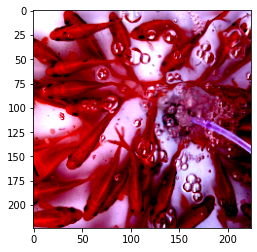

In [149]:
print(next(iter(train_loader_1))[0][0].size())
X,Y=next(iter(train_loader_1))
print(Y[0])


plt.imshow(X[23].numpy().transpose(1,2,0))
plt.show()